In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
od.download('https://www.kaggle.com/datasets/jessicali9530/celeba-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saranaranjomarin
Your Kaggle Key: ··········


100%|██████████| 1.33G/1.33G [00:22<00:00, 62.1MB/s]


In [4]:
import numpy as np
import pandas as pd
import os

PIC_DIR = f'celeba-dataset/img_align_celeba/img_align_celeba/'
    
from tqdm import tqdm
from PIL import Image

IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))


100%|██████████| 10000/10000 [00:18<00:00, 536.34it/s]


In [5]:
len(images)

10000

In [6]:
import matplotlib.pyplot as plt

images = np.array(images) / 255
print(images.shape)

(10000, 128, 128, 3)


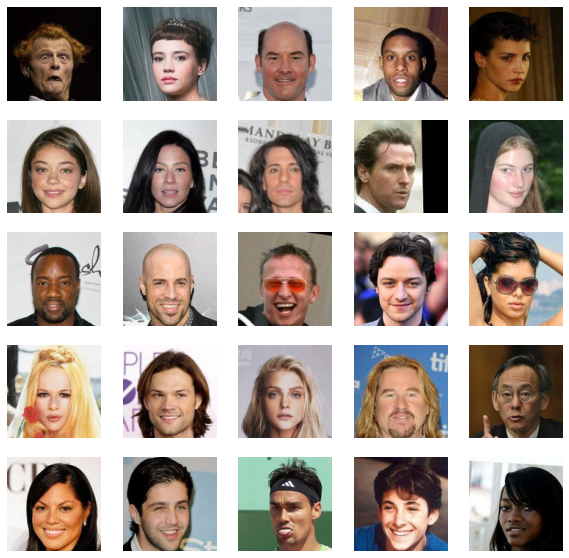

In [7]:
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [8]:
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop

LATENT_DIM = 32
CHANNELS = 3

In [9]:
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator



generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [10]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/GANs/Rostros/"
print(root_dir)

Mounted at /content/drive
/content/drive/My Drive/GANs/Rostros/


In [ ]:
import time
iters = 15000
batch_size = 16

RES_DIR = root_dir + 'Imagenes'
FILE_PATH = '%s/generated_%d.png'

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights(root_dir + 'Modelos/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave(root_dir + 'Imagenes', images_to_gif)
shutil.rmtree(RES_DIR)

50/15000: d_loss: 0.6165,  a_loss: 0.6860.  (6.7 sec)
100/15000: d_loss: 0.6555,  a_loss: 0.8496.  (6.4 sec)
150/15000: d_loss: 0.7519,  a_loss: 1.3341.  (5.2 sec)
200/15000: d_loss: 0.6148,  a_loss: 1.2210.  (6.1 sec)
250/15000: d_loss: 0.7971,  a_loss: 1.3772.  (5.9 sec)
300/15000: d_loss: 0.6180,  a_loss: 0.9744.  (7.3 sec)
350/15000: d_loss: 0.6404,  a_loss: 1.1292.  (6.2 sec)
400/15000: d_loss: 0.5749,  a_loss: 0.9829.  (5.1 sec)
450/15000: d_loss: 0.5889,  a_loss: 0.9825.  (6.0 sec)
500/15000: d_loss: 0.6872,  a_loss: 1.4367.  (6.0 sec)
550/15000: d_loss: 0.6784,  a_loss: 0.7884.  (6.0 sec)
600/15000: d_loss: 0.7125,  a_loss: 0.8162.  (6.0 sec)
650/15000: d_loss: 0.7080,  a_loss: 1.0304.  (5.1 sec)
700/15000: d_loss: 0.7175,  a_loss: 0.9944.  (6.0 sec)
750/15000: d_loss: 0.6165,  a_loss: 0.9448.  (6.7 sec)
800/15000: d_loss: 0.7199,  a_loss: 0.8599.  (5.6 sec)
850/15000: d_loss: 0.6864,  a_loss: 0.7954.  (5.1 sec)
900/15000: d_loss: 0.7103,  a_loss: 0.8879.  (6.2 sec)
950/15000: 